## Importations

In [1]:
import pandas as pd
import numpy as np
import sqlalchemy as sql
import configparser
import datetime
import seaborn as sns
import matplotlib.pyplot as plt 
import re
import boto3
import io
import json


Bad key "text.kerning_factor" on line 4 in
/home/ubuntu/anaconda3/envs/analytics/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


## Configuration

In [2]:
config = configparser.ConfigParser()
config.read('../config/default.ini')

['../config/default.ini']

In [3]:
engine = sql.create_engine('postgresql://{}:{}@{}:{}/{}'.format(config['DATABASE']['username'], config['DATABASE']['password'].replace('_percentage_', '%'), config['DATABASE']['host'], config['DATABASE']['port'], config['DATABASE']['database']))

In [4]:
s3 = boto3.client('s3')

s3_resource = boto3.resource('s3')
bucket = 'big-data-media'  

## Utilitaires

In [5]:
def export_df(df, name, date=True):
    df.to_csv('output/{}{}.csv'.format('{}_'.format(datetime.datetime.strftime(datetime.datetime.now(), '%y%m%d')) if date else '', name), index=False, encoding='utf-8-sig')

In [6]:
def export_fig(plot, name, date=True):
    plot.savefig('images/{}{}.png'.format('{}_'.format(datetime.datetime.strftime(datetime.datetime.now(), '%y%m%d')) if date else '', name))

In [7]:
def path_formating(path):
    if 'rtbf.be/auvio/' in path:
        return np.nan
    match = re.search('\?id=[0-9]+($|&)', path)
    if match is not None:
        articleid = path[match.start()+4: match.end()]
        if articleid[-1] == '&':
            return articleid[:-1]
        else:
            return articleid
    else:
        np.nan

## Données

In [10]:
obj_articles = s3.get_object(Bucket=bucket, Key='playground/chartbeat/article_metrics.csv')
df_articles = pd.read_csv(io.BytesIO(obj_articles['Body'].read()))
df_articles.head()

datetime  articleid  nb_words  total_time  page_views  \
0  2020-09-09 00:00:00         10     673.0         675          59   
1  2020-09-09 00:00:00   10000200     356.0         104           5   
2  2020-09-09 00:00:00   10000203     272.0           7           1   
3  2020-09-09 00:00:00   10000267     878.0         889          23   
4  2020-09-09 00:00:00   10000307     217.0          25           1   

                                                path  
0      rtbf.be/vivacite/replay?id=10&date=2019/04/17  
1  rtbf.be/info/societe/detail_un-jour-dans-l-inf...  
2  rtbf.be/tendance/mode/tendances/detail_costume...  
3  rtbf.be/tendance/mode/astuces/detail_5-erreurs...  
4  rtbf.be/tv/detail_l-annee-des-meduses-un-amour...

In [12]:
df = df_articles.copy()

In [14]:
df['datetime'] = df['datetime'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:00'))
df['articleid'] = df['articleid'].astype(int)
df['page_views'] = df['page_views'].astype(int)
df['total_time'] = df['total_time'].astype(int)
df['nb_words'] = df['nb_words'].apply(lambda x: int(x) if x == x and x != '' else 0)   
df.head()

datetime  articleid  nb_words  total_time  page_views  \
0 2020-09-09         10       673         675          59   
1 2020-09-09   10000200       356         104           5   
2 2020-09-09   10000203       272           7           1   
3 2020-09-09   10000267       878         889          23   
4 2020-09-09   10000307       217          25           1   

                                                path  
0      rtbf.be/vivacite/replay?id=10&date=2019/04/17  
1  rtbf.be/info/societe/detail_un-jour-dans-l-inf...  
2  rtbf.be/tendance/mode/tendances/detail_costume...  
3  rtbf.be/tendance/mode/astuces/detail_5-erreurs...  
4  rtbf.be/tv/detail_l-annee-des-meduses-un-amour...

In [16]:
csv_buffer = io.StringIO()
df.to_csv(csv_buffer, index=False, sep='\t', encoding='utf-8-sig', date_format='%Y-%m-%d %H:%M:%S', na_rep='0')
s3_resource.Object(bucket, 'playground/chartbeat/article_metrics.csv').put(Body=csv_buffer.getvalue())

{'ResponseMetadata': {'RequestId': '4DC51B6039782375',
  'HostId': 'Nq2C1epLnuGRsxfyzYKC2jLav5tn8rJCo+PAh4dIOAvvfvBJtO3pe4jf7EWlPdrUAsLvyAw+0jQ=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'Nq2C1epLnuGRsxfyzYKC2jLav5tn8rJCo+PAh4dIOAvvfvBJtO3pe4jf7EWlPdrUAsLvyAw+0jQ=',
   'x-amz-request-id': '4DC51B6039782375',
   'date': 'Wed, 02 Dec 2020 07:40:56 GMT',
   'x-amz-version-id': 'rrFENZGGRkfZoUfH_ZOwOswzCVnN083s',
   'etag': '"b49283210295346a2939ded002e06f25"',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"b49283210295346a2939ded002e06f25"',
 'VersionId': 'rrFENZGGRkfZoUfH_ZOwOswzCVnN083s'}

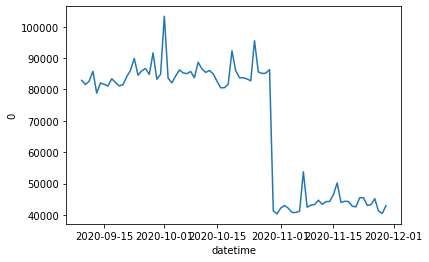

In [17]:
sns.lineplot(x='datetime',y=0,data=df.groupby(['datetime']).size().reset_index())

In [16]:
df_pageviews = df.groupby(['datetime']).sum().reset_index()
df_pageviews.head()

datetime     articleid    nb_words  total_time  page_views
0  2020-09-09 00:00  797602650502  30180848.0    72461446     2337296
1  2020-09-10 00:00  785707388424  29758202.0    64265978     2161188
2  2020-09-11 00:00  796657436702  29991596.0    57017360     1864008
3  2020-09-12 00:00  821782633164  30448052.0    59828886     2169686
4  2020-09-13 00:00  758844217290  28537446.0    51275092     1929042

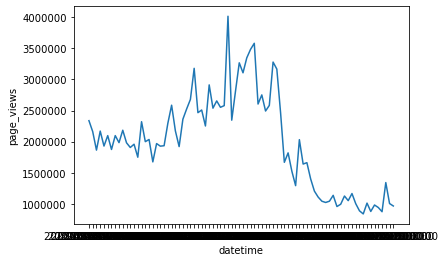

In [17]:
sns.lineplot(x='datetime',y='page_views',data=df_pageviews)

In [ ]:
with engine.connect() as connection:
    with connection.begin():
        r1 = connection.execute(table1.select())
        connection.execute(table1.insert(), {"col1": 7, "col2": "this is some data"})

In [27]:
df['nb_words'] = df['nb_words'].apply(lambda x: int(x) if x == x else '')

In [28]:
with engine.connect() as connection:
    with connection.begin():
        for i,row in df.iterrows():
            connection.execute("""INSERT INTO article_metrics VALUES ('{}','{}','{}','{}','{}','{}')""".format(row['datetime'],row['articleid'],row['nb_words'],row['total_time'],row['page_views'],row['path']))

In [ ]:
sns.lineplot(x='datetime',y=0,data=)

In [13]:
df_counts = df.groupby(['datetime']).size().reset_index()

In [14]:
df_counts[df_counts['datetime']]

51    2020-10-30 00:00
52    2020-10-31 00:00
53    2020-11-01 00:00
54    2020-11-02 00:00
55    2020-11-03 00:00
56    2020-11-04 00:00
57    2020-11-05 00:00
58    2020-11-06 00:00
59    2020-11-07 00:00
60    2020-11-08 00:00
61    2020-11-09 00:00
62    2020-11-10 00:00
63    2020-11-11 00:00
64    2020-11-12 00:00
65    2020-11-13 00:00
66    2020-11-14 00:00
67    2020-11-15 00:00
68    2020-11-16 00:00
69    2020-11-17 00:00
70    2020-11-18 00:00
71    2020-11-19 00:00
72    2020-11-20 00:00
73    2020-11-21 00:00
74    2020-11-22 00:00
75    2020-11-23 00:00
76    2020-11-24 00:00
77    2020-11-25 00:00
78    2020-11-26 00:00
79    2020-11-27 00:00
80    2020-11-28 00:00
81    2020-11-29 00:00
Name: datetime, dtype: object

In [61]:
path_formating('rtbf.be/acces?redirect=https://www.rtbf.be/info/societe/detail_coronavirus-vous-avez-un-test-pcr-positif-et-vous-ne-l-etes-peut-etre-pas-ou-vous-n-etes-pas-contagieux?id=10578123&utm_source=rtbfinfo&utm_campaign=social_share&utm_medium=fb_share&fbclid=IwAR0telTOqZVqyWZv59I9lfO5YCBIm9M5s3mtGP_5lylzV_0i3fjO7DAINMk&scope=newsletter&register=0')

'10578123'

In [62]:
df['articleid'] = df['path'].apply(path_formating)

In [67]:
export_df(df_clean.head(100), 'to_check')

In [98]:
df_clean = df[~df['articleid'].isna()]
df_clean['len'] = df_clean['path'].str.len()
len(df_clean)

/home/ubuntu/anaconda3/envs/analytics/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


2234226

In [99]:
df_clean.head()

datetime articleid  nb_words  total_time  page_views  \
2  2020-09-09 00:00  10578238       NaN           0           1   
3  2020-09-09 00:00  10578238       NaN           0           1   
5  2020-09-09 00:00  10579748     775.0           7           4   
6  2020-09-09 00:00  10067920    1439.0         126           5   
7  2020-09-09 00:00   8285152     260.0           0           1   

                                                path  len  
2  local.rtbf.be/tipik/detail_retrouvez-les-sport...  116  
3  local.rtbf.be/tipik/detail_retrouvez-les-sport...  140  
5  me.rtbf.be/article/simple/detail/preview/exter...  139  
6  rtbf.be/14-18/actualites/actualite_sept-anecdo...   91  
7  rtbf.be/14-18/article_bruxelles-monument-a-l-i...   72

In [100]:
df_clean = df_clean.sort_values(['datetime','articleid','len'])
df_clean.head()

datetime articleid  nb_words  total_time  page_views  \
56725  2020-09-09 00:00        10     673.0           0           1   
56726  2020-09-09 00:00        10     673.0           0           1   
56727  2020-09-09 00:00        10     673.0          20           3   
56728  2020-09-09 00:00        10     673.0         135          12   
56729  2020-09-09 00:00        10     673.0         517          40   

                                                path  len  
56725  rtbf.be/vivacite/replay?id=10&date=2019/04/17   45  
56726  rtbf.be/vivacite/replay?id=10&date=2020/09/04   45  
56727  rtbf.be/vivacite/replay?id=10&date=2020/09/05   45  
56728  rtbf.be/vivacite/replay?id=10&date=2020/09/07   45  
56729  rtbf.be/vivacite/replay?id=10&date=2020/09/08   45

In [101]:
df_clean = df_clean.groupby(['datetime','articleid']).agg({'nb_words': 'max', 'total_time': 'sum', 'page_views': 'sum','path': 'first'}).reset_index()
df_clean.head()

datetime articleid  nb_words  total_time  page_views  \
0  2020-09-09 00:00        10     673.0         675          59   
1  2020-09-09 00:00  10000200     356.0         104           5   
2  2020-09-09 00:00  10000203     272.0           7           1   
3  2020-09-09 00:00  10000267     878.0         889          23   
4  2020-09-09 00:00  10000307     217.0          25           1   

                                                path  
0      rtbf.be/vivacite/replay?id=10&date=2019/04/17  
1  rtbf.be/info/societe/detail_un-jour-dans-l-inf...  
2  rtbf.be/tendance/mode/tendances/detail_costume...  
3  rtbf.be/tendance/mode/astuces/detail_5-erreurs...  
4  rtbf.be/tv/detail_l-annee-des-meduses-un-amour...

In [87]:
df_clean = df_clean[['datetime','articleid','total_time','page_views']].merge(df_metadata, left_on='articleid', right_on='mediaid', how='left')
df_clean.head()

datetime articleid  total_time  page_views   mediaid  nb_words
0  2020-09-09 00:00        10         675          59        10     673.0
1  2020-09-09 00:00  10000200         104           5  10000200     356.0
2  2020-09-09 00:00  10000203           7           1  10000203     272.0
3  2020-09-09 00:00  10000267         889          23  10000267     878.0
4  2020-09-09 00:00  10000307          25           1  10000307     217.0

In [88]:
df_clean = df_clean.merge(df_path, on='articleid')
df_clean.head()

datetime articleid  total_time  page_views mediaid  nb_words  \
0  2020-09-09 00:00        10         675          59      10     673.0   
1  2020-09-09 00:00        10         675          59      10     673.0   
2  2020-09-09 00:00        10         675          59      10     673.0   
3  2020-09-09 00:00        10         675          59      10     673.0   
4  2020-09-09 00:00        10         675          59      10     673.0   

                                            path  
0                rtbf.be/vivacite/concours?id=10  
1              rtbf.be/vivacite/conducteur?id=10  
2             rtbf.be/classic21/hit-parade?id=10  
3         rtbf.be/vivacite/concours?id=10&page=1  
4  rtbf.be/vivacite/replay?id=10&date=2020/09/23

In [18]:
export_df(df[['path']].head(1000), 'temp_auvio')

In [11]:
export_df(df[df['articleid'] == 2336017132668], 'temp')

In [9]:
df.iterrows()

<generator object DataFrame.iterrows at 0x7fdd67612ed0>

In [12]:
df.count()

actitoid                            3538392
firstname                           3538392
lastname                            3538392
email                               3538392
birthdate                           3538392
language                            3538392
gender                              3538392
gsmnumber                           3538392
telnumber                           3538392
educationlevel                      3538392
profession                          3538392
is_gigya                             977631
marketingconsent                          2
addr_street                         3538392
addr_num                            3538392
addr_box                            3538392
city                                3538392
zip                                 3538392
country                             3538392
is_active                           3538392
blacklistrm                         3538392
source                              3538392
sourceoptin                     

In [ ]:
df.shape

In [ ]:
df.isnull().any()

## Graphs

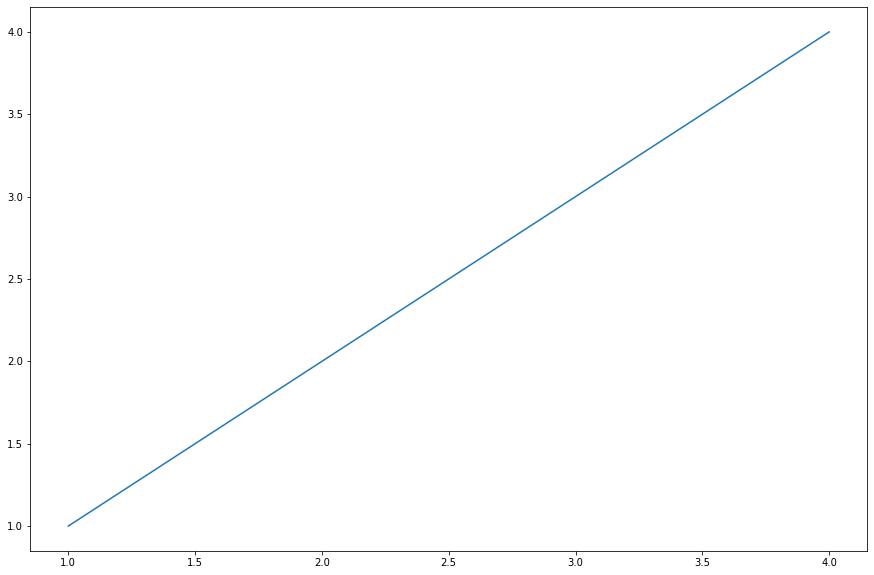

In [2]:
plt.figure(figsize = (15,10))
sns.lineplot(x=[1,2,3,4], y=[1,2,3,4])
plt.show()